In [67]:
import sqlite3
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate





In [68]:
def calculate_distance(lat1, lon1):
    # Radius of the Earth in kilometers
    earth_radius = 6371

    # Convert latitude and longitude to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(44.4914)
    lon2_rad = math.radians(20.2744)

    # Calculate the differences between the latitudes and longitudes
    d_lat = lat2_rad - lat1_rad
    d_lon = lon2_rad - lon1_rad

    # Apply the Haversine formula
    a = math.sin(d_lat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(d_lon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = earth_radius * c

    return distance

In [69]:
import sqlite3

values = ["SUT", "PSUT", "PR", "VPR"]

mapping = {
    "SUT": 0,
    "PSUT": 0.25,
    "PR": 0.5,
    "VPR": 0.75
}

# Connect to the database
conn = sqlite3.connect('db_prodaja-stanova_beograd.db')

# Create a cursor object
cursor = conn.cursor()
df = pd.read_sql_query("SELECT * FROM mytable", conn)

# Execute a SELECT query
cursor.execute("SELECT * FROM mytable")

X_data = list()
Y_data = list()
full_data = list()

# Fetch and print rows one by one
row1 = cursor.fetchone()
row = cursor.fetchone()
while row is not None:
    # print(row)
    coordinates = row[4]
    latitude, longitude = coordinates.split(',')
    distance = calculate_distance(float(latitude), float(longitude))
    

    broj_soba = row[5]

    if broj_soba == None:
        row = cursor.fetchone()
        continue
    broj_soba = float(broj_soba) if broj_soba != '5+' else 5.0


    kvadratura = float(row[6])
    if kvadratura == None:
        row = cursor.fetchone()
        continue


    sprat = row[7]
    if sprat == None:
        row = cursor.fetchone()
        # print(sprat)
        continue
    if sprat in values:
        sprat = mapping[sprat]
    else:
        sprat = float(sprat)
    sprat = math.log2(sprat + 1)


    # print(row)

    tip_gradnje = row[8]
    tip_gradnje = 1 if tip_gradnje == 'Novogradnja' else 0
    # else:
    #     break
    uknjizen = float(row[9])
    lift = float(row[10])
    garaza = float(row[11])
    terasa = float(row[12])
    pdv = float(row[13])

    cena = float(row[16])
    # , legal, air_c, elevator, garage

    row_x_data = [distance, broj_soba, kvadratura, sprat, cena]
    row_full_data = [distance, broj_soba, kvadratura, sprat, cena]
    full_data.append(row_full_data)
    X_data.append(row_x_data)
    Y_data.append(cena)

    row = cursor.fetchone()

# Close the connection
conn.close()

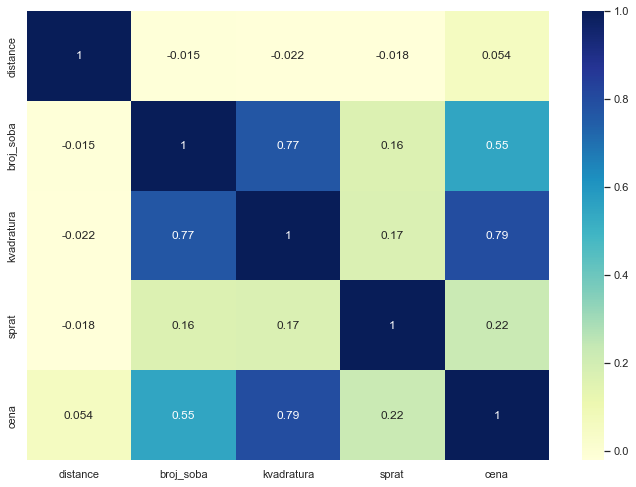

In [70]:
header = ['distance', 'broj_soba', 'kvadratura', 'sprat', 'cena']
df = pd.DataFrame(full_data, columns=header)
# price_ranges = [0, 50000, 100000, 150000, 200000, 500000, float('inf')]
# categories = [0,1,2,3,4,5]
# corrM = df.corr()
# corrM
sns.set(rc={'figure.figsize':(11.7,8.27)})
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

In [71]:
# df['cena'] = pd.cut(df['cena'], bins=price_ranges, labels=categories)
df.head()

,distance,broj_soba,kvadratura,sprat,cena
0,39.127679,3.0,68.0,1.000000,194000.0
1,35.570932,2.5,75.0,3.459432,155000.0
2,34.167384,3.0,69.0,2.000000,265000.0
3,37.692401,4.0,146.0,4.169925,665000.0
4,37.751948,4.0,125.0,2.000000,480000.0


In [72]:
header = ['distance', 'broj_soba', 'kvadratura', 'sprat', 'cena']
df_x = pd.DataFrame(X_data, columns=header)
y_data = df_x['cena']
MinMaxScaler = preprocessing.MinMaxScaler()
df_x.pop("cena")

X1 = df_x.values
y = y_data.values
# X_data_minmax = MinMaxScaler.fit_transform(X_data)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,test_size=0.2, random_state = 1)
X_train = MinMaxScaler.fit_transform(X_train)
X_test = MinMaxScaler.fit_transform(X_test)

In [74]:
from sklearn.model_selection import KFold

k = 4
kf = KFold(n_splits=k, shuffle=True)

In [75]:
for train_index, test_index in kf.split(X, y):
    print("Train:", train_index)
    print("Test:", test_index)
    print('-------')

Train: [    0     2     3 ... 11979 11981 11983]
Test: [    1     4    13 ... 11969 11980 11982]
-------
Train: [    1     2     4 ... 11981 11982 11983]
Test: [    0     3     9 ... 11968 11973 11974]
-------
Train: [    0     1     2 ... 11980 11982 11983]
Test: [    7    17    19 ... 11977 11979 11981]
-------
Train: [    0     1     3 ... 11980 11981 11982]
Test: [    2     5     6 ... 11976 11978 11983]
-------


(9587, 3)
(9587, 4)
(9587, 10)
(9587, 20)
(9587, 35)
[11878081398.479797, 11871164312.536972, 13043556066.399422, 38997930130.86875]


Text(0.5, 1.0, 'MSE VS Degree')

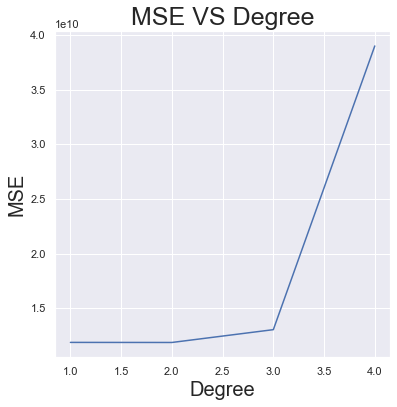

In [83]:
X = MinMaxScaler.fit_transform(X1)
x_train,x_test,y_train,y_test=train_test_split(X[:,:-1],y,train_size=0.8)
print(np.shape(x_train))
maxdegree=5 # The maximum degree we would like to test
training_error=[]
cross_validation_error=[]
for d in range(1,maxdegree):
    x_poly_train=PolynomialFeatures(degree=(0,d)).fit_transform(x_train)
    print(np.shape(x_poly_train))
    x_poly_test=PolynomialFeatures(degree=(0,d)).fit_transform(x_test)
    model=LinearRegression(for_intercept = False)
    model=model.fit(x_poly_train,y_train)
    y_train_pred=model.predict(x_poly_train)
    mse_train=mean_squared_error(y_train,y_train_pred)
    cve=cross_validate(model,x_poly_train,y_train,scoring='neg_mean_squared_error',cv=5,return_train_score=True)
    training_error.append(mse_train)
    cross_validation_error.append(np.mean(np.absolute(cve['test_score'])))
fig,ax=plt.subplots(figsize=(6,6))
print(cross_validation_error)
ax.plot(range(1,maxdegree),cross_validation_error)
ax.set_xlabel('Degree',fontsize=20)
ax.set_ylabel('MSE',fontsize=20)
ax.set_title('MSE VS Degree',fontsize=25)

In [77]:
# test_mse = []
# degrees = range(1, 21)


# for train_index, test_index in kf.split(X, y):
    
#     split_mse = []
    
#     for deg in degrees:
        
#         w = np.polyfit(X[train_index], y[train_index], deg)
#         y = np.polyval(w, X[test_index])
        
#         mse = np.mean((t[test_index] - y)**2)
#         split_mse.append(mse)
    
#     test_mse.append(split_mse)
        
# test_mse = np.mean(test_mse, axis=0)

# for deg, mse in zip(degrees, test_mse):
#     print(deg, mse)

# plt.figure(figsize=(10, 6))
# plt.plot(degrees, test_mse)
# plt.xlabel("Degree of the polynome")
# plt.ylabel("k-fold cross-validated mse")
# plt.show()

In [78]:
PolynomialFeatures(degree=(0,2)).fit_transform([[1,2,3,4]])


array([[ 1.,  1.,  2.,  3.,  4.,  1.,  2.,  3.,  4.,  4.,  6.,  8.,  9.,
        12., 16.]])